# Prerequisites

In [1]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

Using TensorFlow backend.


# Prepare Data

In [2]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

In [3]:
n_diff = 1

for price in prices:
  price.scaled, price.scaler = data_transform(price, method='minmax')
  price.scaled_diff = price.scaled.diff(n_diff).dropna() if n_diff>0 else price.scaled
  price.n_diff = n_diff
  price.train, price.validate, price.train2, price.test = data_split(price.scaled_diff)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)

hml 258 85 85
wht 258 85 85
glu 258 85 85


# LSTM

## Define functions
- lstm_fit
- lstm_forecast
- lstm_walk_forward

In [4]:
def lstm_fit(data, config, n_forecast=4):

  # unpack config
  n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config

  # transform to kreas format
  x, y, date_idx = data_2keras(data, n_lag=n_lag, n_forecast=n_forecast)
  x = x.to_numpy()
  y = y.to_numpy()
  x = x.reshape((x.shape[0], x.shape[1], 1)) # reshape

  # define model
  if n_layers==3:
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_lag+1, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')
    
  elif n_layers==2:
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_lag+1, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')
    
  else:
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_lag+1, 1)))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')

  # fit model
  model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)

  return model


def lstm_forecast(model_fitted, data, date, n_forecast=4):
  """
  Forecast LSTM model

  Args:
      model_fitted (model): Keras fitted model
      data (dataframe): number of lags to be used in the model
      date (date): first date to forecast
      n_fcast (int): number of steps to forecast

  Returns:

  """
  n_diff = getattr(data, "n_diff")
  scaler = getattr(data, "scaler")
  
  x_idx = data.scaled_diff.index.get_loc(date)+1
  x_t   = data.scaled.iloc[x_idx].to_numpy()
  n_input = model_fitted.input_shape[1]

  # find-input
  x = data.scaled_diff.iloc[x_idx-n_input:x_idx,]
  x_input = x.to_numpy().reshape((1, x.shape[0], 1))
  
  # forecast
  yhat = model_fitted.predict(x_input, verbose=0).reshape(-1,)
  yhat = x_t + yhat.cumsum() if n_diff == 1 else yhat # diff adjustment

  K.clear_session()
  df = pd.DataFrame(yhat,
                    columns=["yhat_scaled"],
                    index=pd.date_range(date, periods=n_forecast+1, freq='MS')[1:]
                   )
  df['yhat'] = scaler.inverse_transform(df)
  
  return df['yhat']


def lstm_walk_forward(data, config, search_mode=False, n_forecast=4):
  
  train, test = select_traintest(data, search_mode)
  data_ = pd.concat([train,test])
  N = data_.shape[0]
  n_test = test.shape[0]
  n_yhat = n_test+1
  yhat = np.empty((n_yhat, n_forecast))
  refit_rate = config[-1]
  
  history = train
  model_fitted = lstm_fit(history, config, n_forecast=n_forecast)
  date = train.index[-1]
  
  for i in range(n_yhat):
    model_fitted = lstm_fit(history, config, n_forecast=n_forecast) if i%refit_rate==0 else model_fitted 
    yhat[i] = lstm_forecast(model_fitted, data, date, n_forecast=n_forecast)
    if i < n_yhat-1:
      history = history.append(test.iloc[i])
      date = test.index[i]
      
  yhat = pd.DataFrame(yhat,
                      columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                      index=data_.index[-n_test-1:])

  return yhat

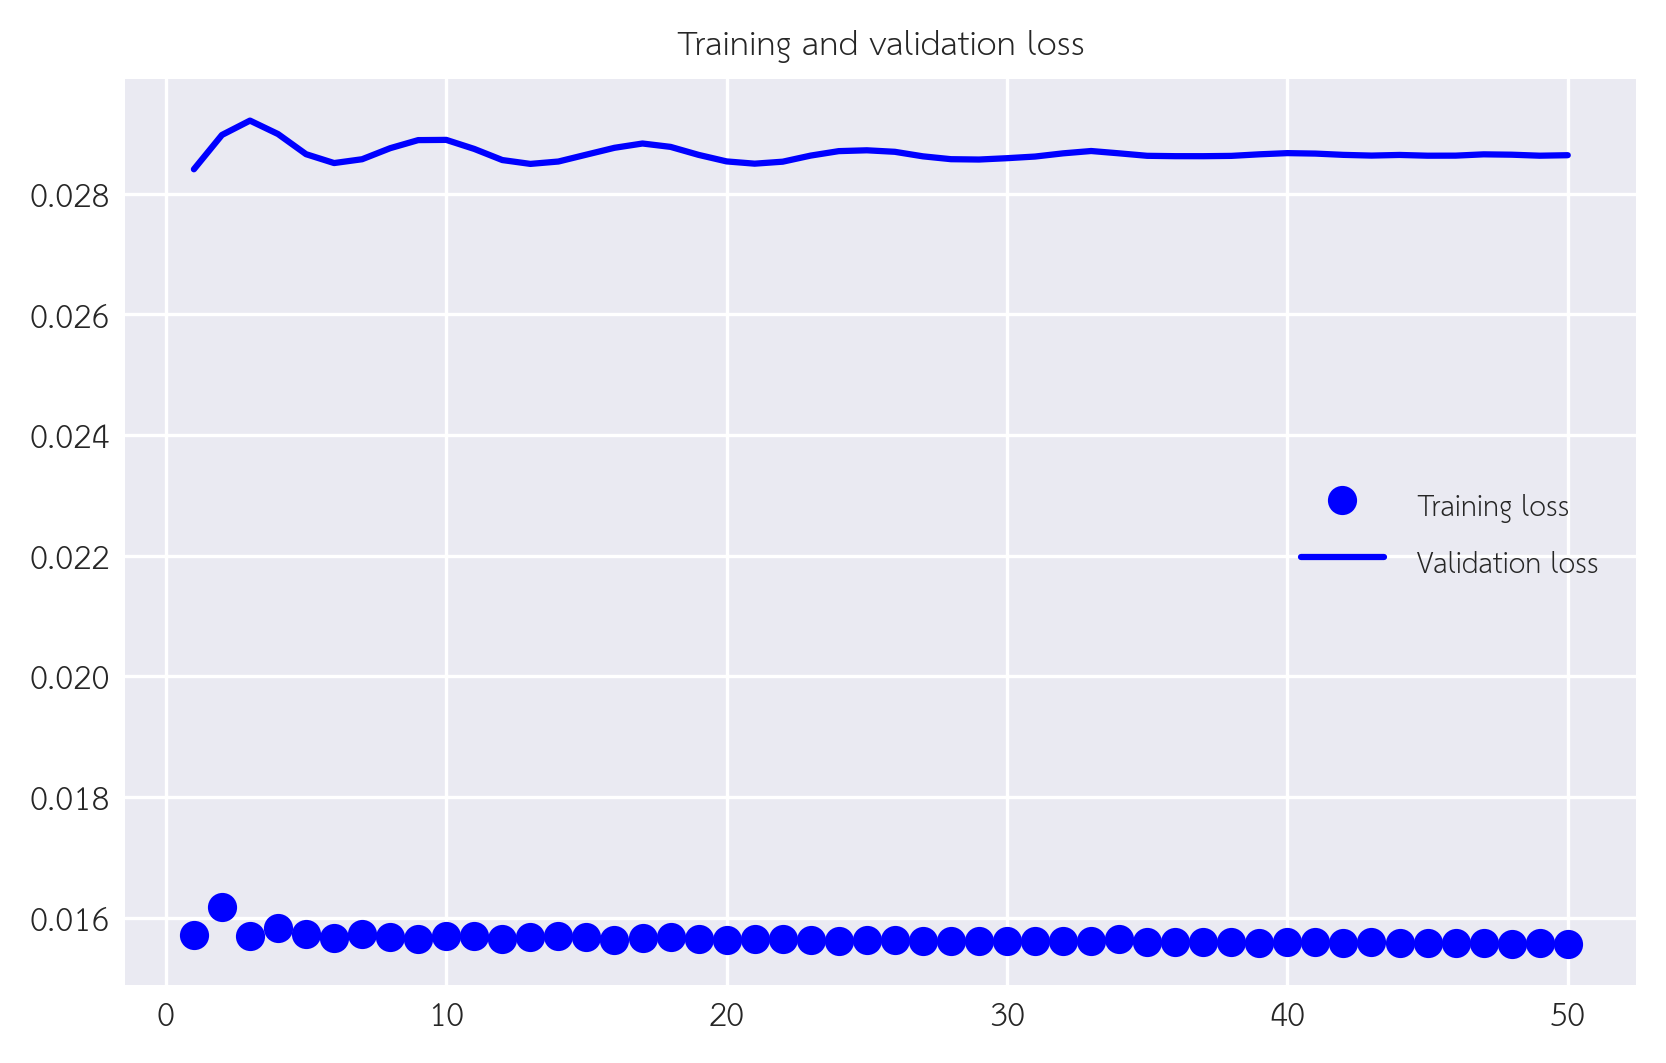

In [10]:
K.clear_session()

n_forecast = 4
n_lag = 5
n_nodes = 200
n_batch = 256
refit_rate = 12
n_epochs = 50

# transform to keras format
data = hml
x, y, date_idx = data_2keras(data.train, n_lag=n_lag, n_forecast=n_forecast)
x = x.to_numpy()
y = y.to_numpy()
x = x.reshape((x.shape[0], x.shape[1], 1)) # reshape

x_val, y_val, date_idx_val = data_2keras(data.validate, n_lag=n_lag, n_forecast=n_forecast)
x_val = x_val.to_numpy()
y_val = y_val.to_numpy()
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1)) # reshape

# define model
model = Sequential()
model.add(LSTM(n_nodes, activation='relu', input_shape=(n_lag+1, 1)))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(n_forecast))
model.compile(loss='mae', optimizer='adam')

# # fit model
history = model.fit(x, y,
                    epochs=n_epochs, batch_size=n_batch, 
                    verbose=0,
                    validation_data=(x_val, y_val))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Generate Parameter Grid

In [17]:
n_input = [12, 24]
n_layers = [1, 2]
n_nodes = [250, 500]
n_epochs = [10]
n_batch = [256]
refit_rate = [24, np.inf]

lstm_configs = model_configs(n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
lstm_model = [lstm_fit, lstm_forecast, lstm_walk_forward, lstm_configs]
lstm_configs

In [18]:
%%time
n_forecast = 4
npr.seed(1305)
for price in prices:
  price.lstm_grid_result, price.lstm_config = grid_search(price, lstm_model, n_forecast=n_forecast)
  price.lstm_yhat = forecast(price, lstm_model, price.lstm_config, n_forecast=n_forecast)

{('5-1-250-10-256-24',): {'rmse': 1220.7081, 'mae': 760.6576, 'mape': 0.0585}}
{('5-1-250-10-256-inf',): {'rmse': 1224.7175, 'mae': 762.9742, 'mape': 0.0585}}
{('5-1-500-10-256-24',): {'rmse': 1216.6704, 'mae': 762.6383, 'mape': 0.0587}}
{('5-1-500-10-256-inf',): {'rmse': 1220.8456, 'mae': 760.0197, 'mape': 0.0583}}
{('5-2-250-10-256-24',): {'rmse': 1227.7894, 'mae': 769.6454, 'mape': 0.0593}}
{('5-2-250-10-256-inf',): {'rmse': 1232.3025, 'mae': 769.1205, 'mape': 0.0591}}
{('5-2-500-10-256-24',): {'rmse': 1235.2417, 'mae': 774.7138, 'mape': 0.0597}}
{('5-2-500-10-256-inf',): {'rmse': 1234.5887, 'mae': 774.3477, 'mape': 0.0596}}
{('11-1-250-10-256-24',): {'rmse': 1222.5418, 'mae': 762.4686, 'mape': 0.0586}}
{('11-1-250-10-256-inf',): {'rmse': 1224.1561, 'mae': 762.3547, 'mape': 0.0585}}
{('11-1-500-10-256-24',): {'rmse': 1229.223, 'mae': 761.3254, 'mape': 0.0583}}
{('11-1-500-10-256-inf',): {'rmse': 1217.4993, 'mae': 757.8979, 'mape': 0.0581}}
{('11-2-250-10-256-24',): {'rmse': 1220.478

In [18]:
for i in prices:
  config = "-".join((str(j) for j in i.lstm_config))
  print(config, '\n', i.lstm_grid_result.loc[config])

5-2-20-10-64-inf 
 rmse   694.0888
mae    398.0416
mape     0.0310
Name: 5-2-20-10-64-inf, dtype: float64
17-2-20-50-64-inf 
 rmse   593.0665
mae    330.1567
mape     0.0355
Name: 17-2-20-50-64-inf, dtype: float64
17-2-10-20-64-inf 
 rmse   721.7177
mae    520.9508
mape     0.0520
Name: 17-2-10-20-64-inf, dtype: float64


In [19]:
model_measure(hml, hml.lstm_yhat, ['hml'])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
hml,909.5917,640.7763,0.0519,491.5701,333.9999,0.0272,815.5167,573.2109,0.0464,"1,062.3748",745.2968,0.0604,"1,268.9052",910.5975,0.0737


In [20]:
model_measure(wht, wht.lstm_yhat, ['wht'])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
wht,486.0984,372.7718,0.0465,294.2129,222.3338,0.0274,462.4860,369.1383,0.0459,567.2129,435.1137,0.0544,620.4816,464.5012,0.0583


In [21]:
model_measure(glu, glu.lstm_yhat, ['glu'])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
glu,864.4622,643.7817,0.0589,518.1468,360.9017,0.0331,796.4941,584.3036,0.0537,988.2399,750.5560,0.0690,"1,154.9681",879.3655,0.0799


In [22]:
path = '../results/result_lstm_4.pkl'
result = dict()

if(os.path.isfile(path)):
    result = joblib.load(path)
else:
    for price in prices:
        result[price.meta.abb] = [price.lstm_grid_result, price.lstm_config, price.lstm_yhat]
    joblib.dump(result, path)

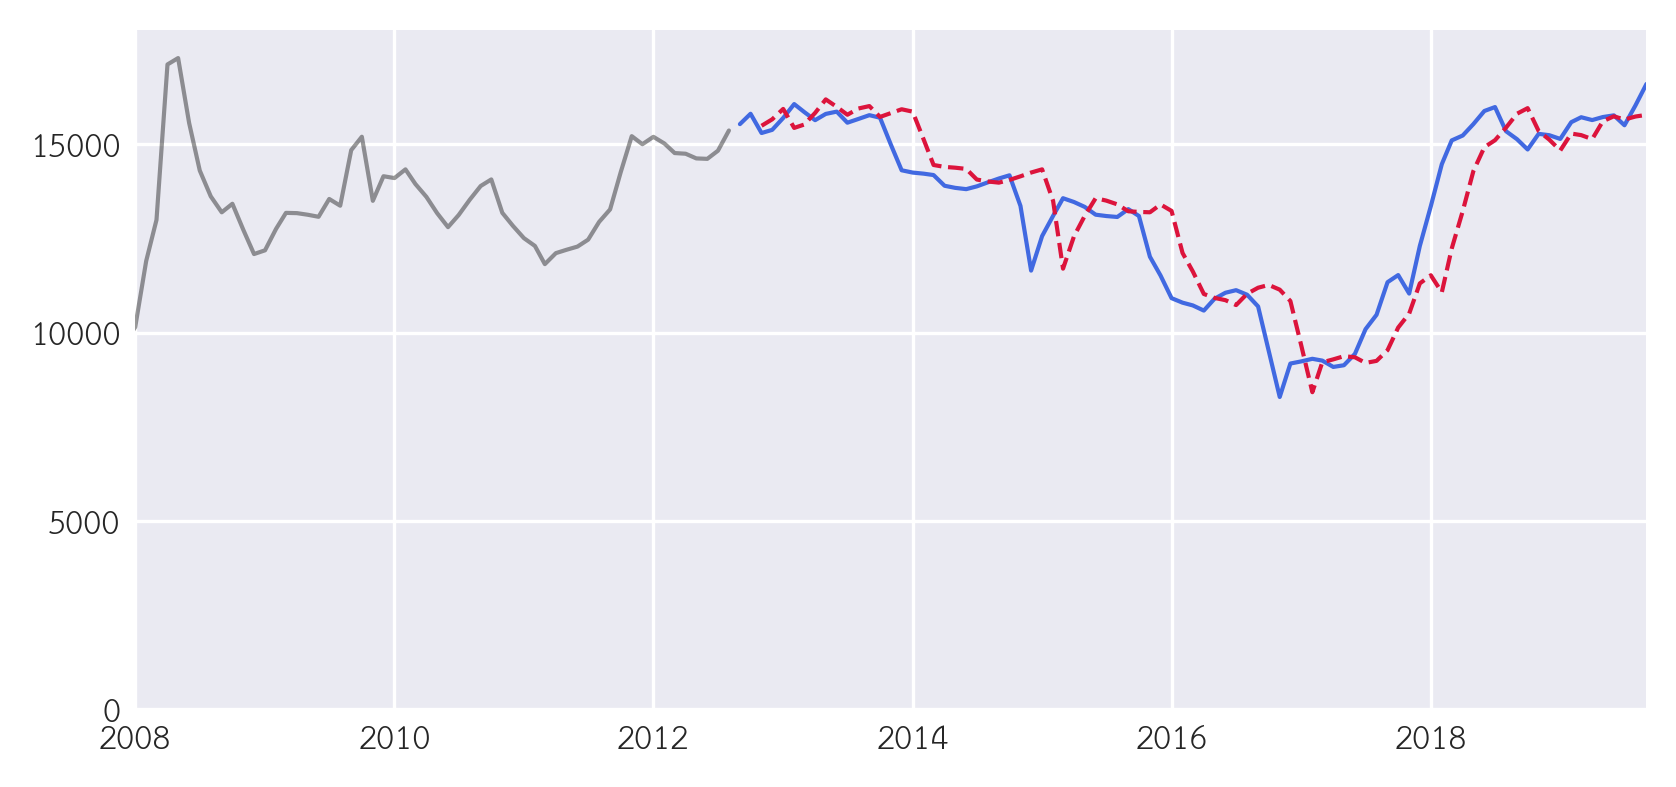

In [16]:
plot_fcast(hml, 'lstm', step=4)

In [12]:
hml.lstm_config

(12, 2, 20, 50, 150, inf)

In [13]:
wht.lstm_config

(6, 1, 20, 50, 50, inf)

In [14]:
glu.lstm_config

(6, 1, 20, 50, 150, inf)